## HW02 Code

### Name: Ercan Sen

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2020/comp135/home).

In [159]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [160]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [161]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [162]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [163]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    for deg in polynomials:
        poly = PolynomialFeatures(degree=deg)
        xs = poly.fit_transform(x)
        linreg = linear_model.LinearRegression()
        linreg.fit(xs, y)
        y_pred = linreg.predict(xs)
        prediction_list.append(y_pred)
        error_list.append(mean_squared_error(y, y_pred))
    
    return prediction_list, error_list

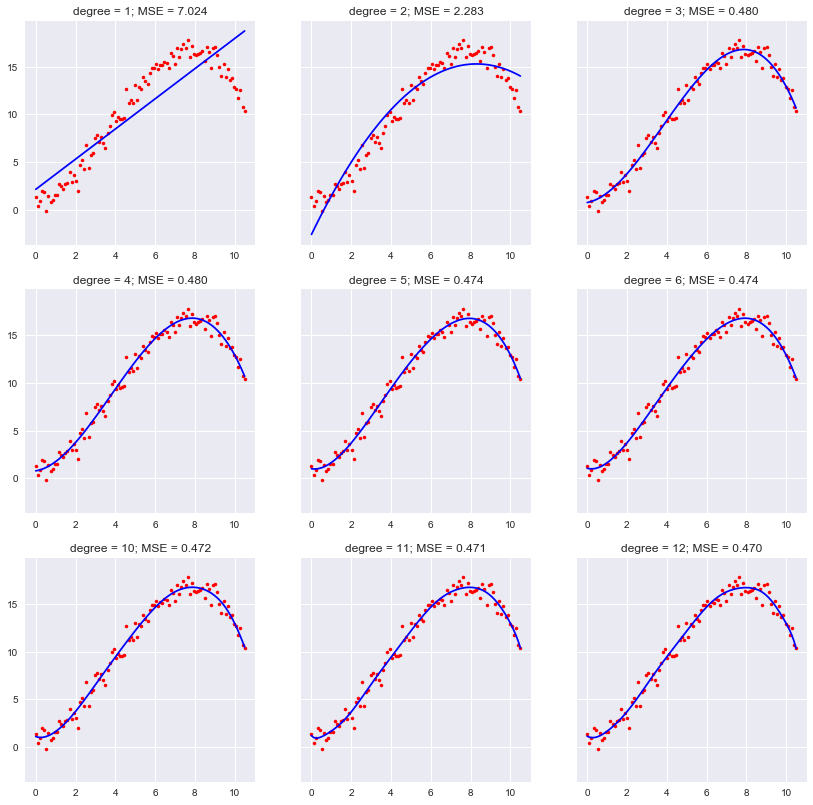

In [164]:
degs = [1, 2, 3, 4, 5, 6, 10, 11, 12]
preds, error = test_polynomials(degs)
plot_predictions(degs, preds, error)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  Resulting curves and MSE values for the polynomials of degree 1 and 2, a.k.a linear and quadratic, show us that these two models do not capture the variability in our data very well. The subsequent polynomials of degree 3-12 all do a better job with relatively low MSE values. However, as the polynomial model's order gets increasing, we are at a higher risk of overfitting and hence not obtaining a model that is generalizable to other unseen data points. As we examine the polynomials of degree 3 all the way up to 12, we notice that the MSE values only varied from 0.480 to 0.470. As this is not a very substantial change in error level, we can conclude that the order-3 model is the best one for our problem.

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [165]:
def make_folds(num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    
    x_folds = list()
    y_folds = list()
    
    step = int(x.size / num_folds)
    
    for i in range(0, x.size, step):
        x_folds.append(x[i:i+step])
        y_folds.append(y[i:i+step])
    
    return x_folds, y_folds

In [166]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
k = 5
x_folds, y_folds = make_folds(k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

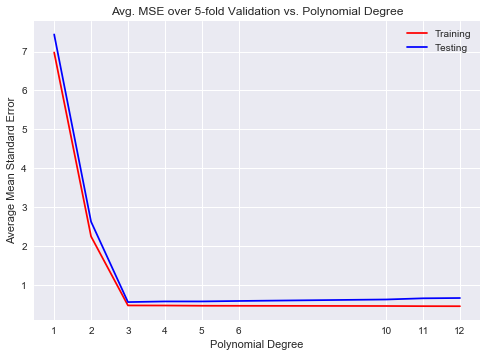

        Training Error (MSE)  Testing Error (MSE)
Degree                                           
1                   6.977641             7.441157
2                   2.245920             2.625608
3                   0.471621             0.558083
4                   0.469909             0.574623
5                   0.463663             0.574580
6                   0.462069             0.586606
10                  0.457199             0.624747
11                  0.453294             0.654945
12                  0.451891             0.662576


In [167]:
final = list()

for deg in degs:
    train_errs = list()
    test_errs = list()
    for i in range(k):
        x_test = x_folds[0] # always removes Fold 0, since removing first elt and then appending sends it to back
        x_folds.remove(x_test)
        x_train = np.concatenate(x_folds, axis=0)

        y_test = y_folds[0]
        y_folds.remove(y_test)
        y_train = np.concatenate(y_folds)

        poly = PolynomialFeatures(degree=deg)
        xs_train = poly.fit_transform(x_train)
        xs_test = poly.fit_transform(x_test)
        linreg = linear_model.LinearRegression()
        linreg.fit(xs_train, y_train)

        y_trained = linreg.predict(xs_train)
        y_pred = linreg.predict(xs_test)

        train_errs.append(mean_squared_error(y_train, y_trained))
        test_errs.append(mean_squared_error(y_test, y_pred))
        x_folds.append(x_test)
        y_folds.append(y_test)

    error_tr = np.mean(train_errs)
    error_te = np.mean(test_errs)
    final.append([deg, error_tr, error_te])

df_final = pd.DataFrame(final, columns = ['Degree', 'Training Error (MSE)', 'Testing Error (MSE)'])
df_final.set_index('Degree',inplace=True)

_ = plt.plot(degs, df_final['Training Error (MSE)'], color='red')
_ = plt.plot(degs, df_final['Testing Error (MSE)'], color='blue')
_ = plt.xlabel('Polynomial Degree')
_ = plt.ylabel('Average Mean Standard Error')
_ = plt.title('Avg. MSE over 5-fold Validation vs. Polynomial Degree')
_ = plt.legend(['Training','Testing'])
_ = plt.xticks(degs)

plt.show()
print(df_final)

#### 2.3 Discuss the results seen in the plots above

**Discussion:** The results confirm the intuitive explanation that was done in response to the plots in Question 1. Training error drops heavily when we move from a polynomial of degree 1 to 2 and 2 to 3, and then keeps decreasing steadily. Testing Error, on the other hand, has its minimum when the polynomial's degree is 3: It has a similar trend as the previous until degree 3, but it slightly increases thereafter. Thus, we can conclude that degrees 1 and 2 demonstrate underfitting, since those two are the ones with the greatest levels of errors on both error metrics, especially relative to the remaining models. Degree 3 polynomial gives us the best model, as Training Error is minimized, which can also be interpreted as our model generalizes to unseen data the most accurately among all. Degrees 4-12 demonstrate overfitting. The training error keeps decreasing as we increase the polynomial degree; however, the model becomes less able to generalize to data it has not trained with, therefore the testing error increases.

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

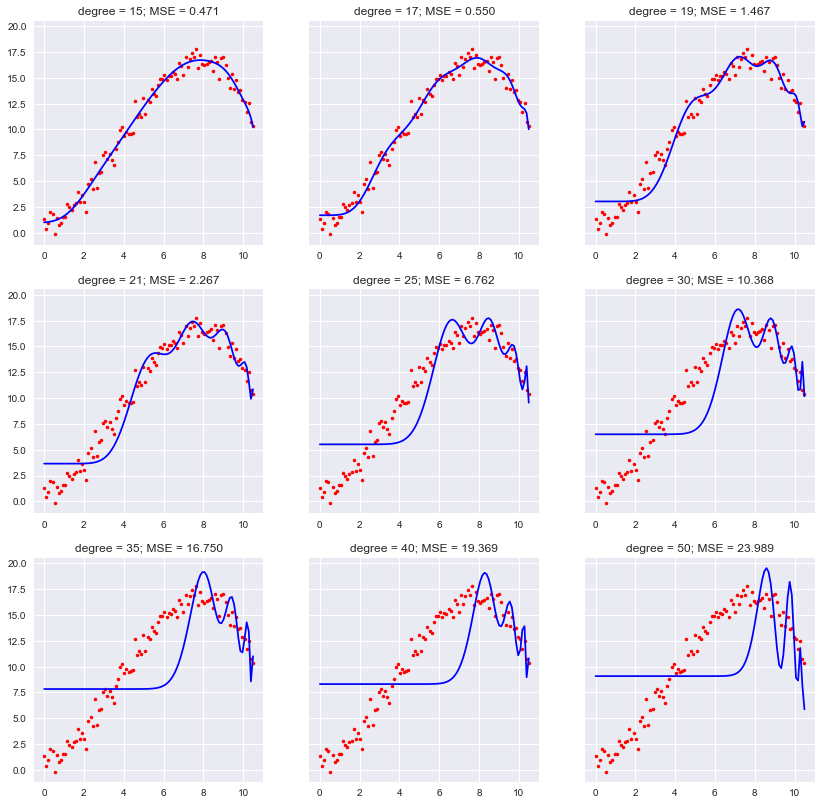

In [168]:
degs2 = [15, 17, 19, 21, 25, 30, 35, 40, 50]
preds, error = test_polynomials(degs2)
plot_predictions(degs2, preds, error)

#### 3.2 Discuss the results seen in the plots above

**Discussion**: The results show that as the degree of the polynomial keeps increasing, the model becomes highly unrepresentative of the data points. Model accuracy drops with each increase in degree and the fitting lines starts to have curves which do not seem to be showing any particular pattern. It might be caused by Runge's phenomenon, which suggests that having a higher degree polynomial does not necessarily improve accuracy.

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree 3, and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

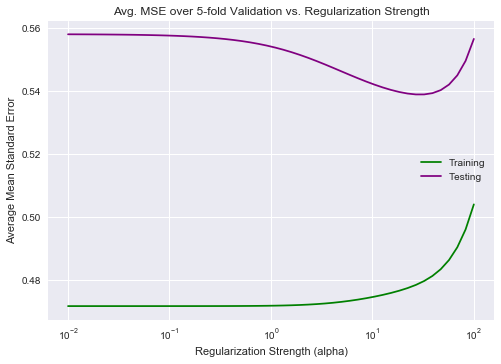

                   Alpha  Training Error  Testing Error
0                   0.01        0.471621       0.558036
1   0.012067926406393288        0.471621       0.558026
2   0.014563484775012436        0.471621       0.558015
3   0.017575106248547922        0.471621       0.558001
4   0.021209508879201904        0.471621       0.557984
5   0.025595479226995357        0.471621       0.557963
6   0.030888435964774818        0.471621       0.557939
7     0.0372759372031494        0.471621       0.557909
8    0.04498432668969444        0.471621       0.557873
9   0.054286754393238594        0.471621       0.557831
10    0.0655128556859551        0.471621       0.557779
11   0.07906043210907697        0.471622       0.557717
12   0.09540954763499938        0.471622       0.557643
13    0.1151395399326447        0.471623       0.557554
14   0.13894954943731375        0.471623       0.557447
15   0.16768329368110074        0.471625       0.557320
16   0.20235896477251566        0.471627       0

In [169]:
alphas = np.logspace(-2, 2, base=10, num=50)
models = list()

pol = PolynomialFeatures(degree=3)

for al in np.nditer(alphas):
    ridge = linear_model.Ridge(alpha=al)
    
    train_errs = list()
    test_errs = list()
    
    for i in range(k):
        x_test = x_folds[0] # always removes Fold 0, since removing first elt and then appending sends it to back
        x_folds.remove(x_test)
        x_train = np.concatenate(x_folds, axis=0)

        y_test = y_folds[0]
        y_folds.remove(y_test)
        y_train = np.concatenate(y_folds)

        xs_train = pol.fit_transform(x_train)
        xs_test = pol.fit_transform(x_test)
    
        ridge.fit(xs_train, y_train)
        y_trained = ridge.predict(xs_train)
        y_pred = ridge.predict(xs_test)

        train_errs.append(mean_squared_error(y_train, y_trained))
        test_errs.append(mean_squared_error(y_test, y_pred))
        x_folds.append(x_test)
        y_folds.append(y_test)

    error_tr = np.mean(train_errs)
    error_te = np.mean(test_errs)
    
    models.append([al, error_tr, error_te])

models_df = pd.DataFrame(models, columns=['Alpha', 'Training Error', 'Testing Error'])

_ = plt.plot(alphas, models_df['Training Error'], color='green')
_ = plt.plot(alphas, models_df['Testing Error'], color='purple')
_ = plt.xlabel('Regularization Strength (alpha)')
_ = plt.ylabel('Average Mean Standard Error')
_ = plt.title('Avg. MSE over 5-fold Validation vs. Regularization Strength')
_ = plt.legend(['Training','Testing'])
_ = plt.xscale('log')

plt.show()
print(models_df)

#### 4.2 Discuss the results seen in the plots above

**Discussion**:  The results show that there is a certain point (between $10^1$ and $10^2$) in the testing error's curve that it is minimized. That point can be thought as the ideal Ridge regularization strength (alpha) value that avoids overfitting to the best extent. Yet, after that point, the accuracy of the model quickly drops which might be caused by putting a very large penalty. Training error is not drastically affected by the change, as it steadily increases, and the point where testing error is minimized is also a point where training error is reasonably low although not the minimum. Hence, ridge model's effect is best observed on that minimum point, and as the regularization strength keeps increasing the accuracy decreases a lot, and therefore incresing further does not better our modeling abilities. 